In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import os
import numpy as np
import pandas as pd
from sklearn import linear_model, preprocessing, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse
import IPython
import copy

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

from influence.inceptionModel import BinaryInceptionModel
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
import influence.experiments as experiments
from influence.image_utils import plot_flat_bwimage, plot_flat_bwgrad, plot_flat_colorimage, plot_flat_colorgrad
from influence.dataset import DataSet
from influence.dataset_poisoning import generate_inception_features

from load_animals import load_animals, load_dogfish_with_koda

sns.set(color_codes=True)

Using TensorFlow backend.


# Attacking multiple test images at once

In [11]:
image_data_sets = load_dogfish_with_koda()
dataset_name = 'dogfish_koda'

train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
train = DataSet(train_f['inception_features_val'], train_f['labels'])
test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
test = DataSet(test_f['inception_features_val'], test_f['labels'])
validation = None

data_sets = base.Datasets(train=train, validation=validation, test=test)

orig_X_train = np.copy(data_sets.train.x)
Y_train = data_sets.train.labels
Y_test = data_sets.test.labels

Loading Koda from disk...
Loading animals from disk...


In [12]:
input_dim = 2048
weight_decay = 0.001
batch_size = 30
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000
num_classes = 2

tf.reset_default_graph()

model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output_ipynb',
    log_dir='log',
    model_name='%s_inception_onlytop' % dataset_name)

model.train()
weights = model.sess.run(model.weights)

orig_Y_train_pred = model.sess.run(model.preds, feed_dict=model.all_train_feed_dict)
orig_Y_pred = model.sess.run(model.preds, feed_dict=model.all_test_feed_dict)


Total number of parameters: 2048
Using normal model
LBFGS training took [41] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.012129
Train loss (w/o reg) on all data: 0.00397613
Test loss (w/o reg) on all data: 0.0350197
Train acc on all data:  1.0
Test acc on all data:   1.0
Norm of the mean of gradients: 3.75189e-07
Norm of the params: 4.03805


In [6]:
# iter_f = np.load('output/dogfish_koda_inception_wd-0.001_attack_normal_loss_testidx-all_dogfish_koda_trainidx-[1141]_stepsize-0.01_proj_iter-1000.npz')
iter_f = np.load('output/dogfish_koda_inception_wd-0.001_attack_normal_loss_testidx-all_dogfish_koda_trainidx-[1141]_stepsize-0.005_proj_iter-2000.npz')
# iter_f = np.load('output/dogfish_koda_inception_wd-0.001_attack_normal_loss_testidx-all_dogfish_koda_trainidx-[1141]_stepsize-0.005_proj_iter-500.npz')
print(iter_f['test_pred'])
print(np.sum(iter_f['test_pred'][:, 0] < 0.5))

[[ 0.9681673   0.0318327 ]
 [ 0.53883511  0.46116483]
 [ 0.07910911  0.92089093]
 [ 0.36935651  0.63064349]
 [ 0.64958537  0.35041466]
 [ 0.09730731  0.90269274]
 [ 0.96310854  0.03689149]
 [ 0.3456015   0.65439856]
 [ 0.56384915  0.43615082]
 [ 0.1267041   0.8732959 ]
 [ 0.7031551   0.29684487]
 [ 0.11562879  0.88437128]
 [ 0.88263911  0.11736088]
 [ 0.476753    0.523247  ]
 [ 0.02188709  0.97811288]
 [ 0.16430952  0.8356905 ]
 [ 0.04568592  0.95431411]
 [ 0.06959597  0.93040401]
 [ 0.03253785  0.96746218]
 [ 0.67729437  0.32270566]
 [ 0.78621769  0.21378234]
 [ 0.01956535  0.98043472]
 [ 0.98522991  0.01477012]
 [ 0.34401503  0.65598494]
 [ 0.60018772  0.39981225]
 [ 0.04530028  0.9546997 ]
 [ 0.87743598  0.12256403]
 [ 0.10540138  0.8945986 ]
 [ 0.79654968  0.20345035]
 [ 0.92487276  0.07512727]]
16


test idx: 2
0.0791091
test idx: 3
0.369357
test idx: 5
0.0973073
test idx: 7
0.345601
test idx: 9
0.126704
test idx: 11
0.115629
test idx: 13
0.476753
test idx: 14
0.0218871
test idx: 15
0.16431
test idx: 16
0.0456859
test idx: 17
0.069596
test idx: 18
0.0325379
test idx: 21
0.0195654
test idx: 23
0.344015
test idx: 25
0.0453003
test idx: 27
0.105401


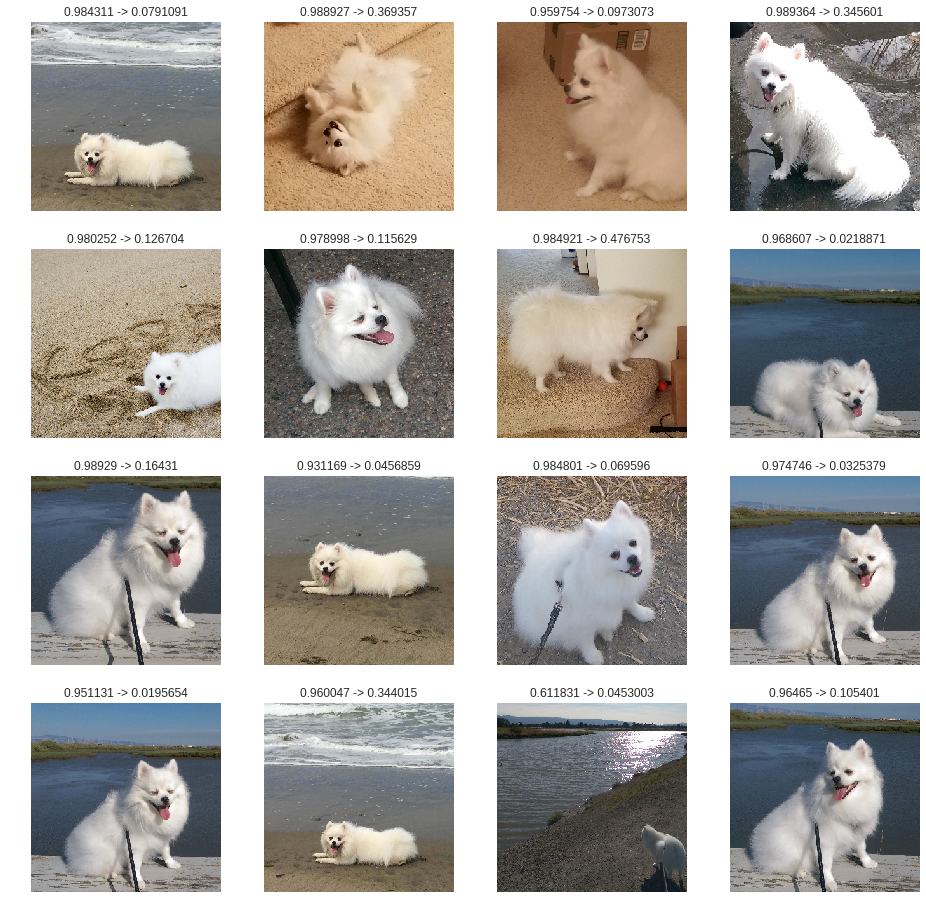

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

row = 0
col = 0

for i in range(len(iter_f['test_pred'])):
    if (iter_f['test_pred'][i, 0] < 0.5):
        print('test idx: %s' % i)
        print(iter_f['test_pred'][i, 0])
#         axs[row][col].imshow((np.reshape(iter_f['poisoned_X_train_image'], [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[row][col].imshow((np.reshape(image_data_sets.test.x[i, :], [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[row][col].axis('off')
        axs[row][col].set_title(
            '%s -> %s' % (
                orig_Y_pred[i, 0], # Change label if using 300 test set
                iter_f['test_pred'][i, 0]))
        col += 1
        if col == 4:
            col = 0
            row += 1
        
# plt.savefig("figs/attack-dog-grid.png", dpi=300, bbox_inches='tight')

### Visualize the change to the training image

0.500003769994
1.0
-1.0


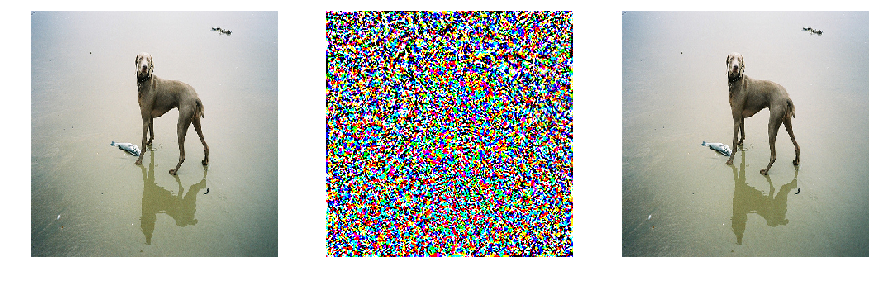

In [14]:
assert len(iter_f['indices_to_poison']) == 1
train_idx = iter_f['indices_to_poison'][0]
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
diff = 0.5 - (255 * (0.5 - (((iter_f['poisoned_X_train_image'] - image_data_sets.train.x[train_idx, :]) + 1) / 2)))
axs[0].imshow((np.reshape(image_data_sets.train.x[train_idx, :], [299, 299, 3]) + 1) / 2, interpolation='none')  
axs[0].axis('off')
axs[1].imshow(np.reshape(diff, [299, 299, 3]), interpolation='none')  
axs[1].axis('off')
axs[2].imshow((np.reshape(iter_f['poisoned_X_train_image'], [299, 299, 3]) + 1) / 2, interpolation='none')  
axs[2].axis('off')

print(np.max(np.abs(image_data_sets.train.x[train_idx, :] - iter_f['poisoned_X_train_image'])) * 255 / 2)
print(np.max(iter_f['poisoned_X_train_image']))
print(np.min(iter_f['poisoned_X_train_image']))

# plt.savefig("figs/attack-before-after.png", dpi=300, bbox_inches='tight')

### Double-check that the attack actually works

In [15]:
### Run the original model to make sure that it gets stuff correct

dataset_name = 'dogfish_koda'

train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
train = DataSet(train_f['inception_features_val'], train_f['labels'])
test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
test = DataSet(test_f['inception_features_val'], test_f['labels'])
validation = None

data_sets = base.Datasets(train=train, validation=validation, test=test)

orig_X_train = np.copy(data_sets.train.x)
Y_train = data_sets.train.labels
Y_test = data_sets.test.labels

input_dim = 2048
weight_decay = 0.001
batch_size = 30
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000
num_classes = 2

tf.reset_default_graph()

model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output_ipynb',
    log_dir='log',
    model_name='%s_inception_onlytop' % dataset_name)

model.train()
weights = model.sess.run(model.weights)

orig_Y_train_pred = model.sess.run(model.preds, feed_dict=model.all_train_feed_dict)
orig_Y_pred = model.sess.run(model.preds, feed_dict=model.all_test_feed_dict)

Total number of parameters: 2048
Using normal model
LBFGS training took [41] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.012129
Train loss (w/o reg) on all data: 0.00397613
Test loss (w/o reg) on all data: 0.0350197
Train acc on all data:  1.0
Test acc on all data:   1.0
Norm of the mean of gradients: 3.75189e-07
Norm of the params: 4.03805


In [16]:
indices_to_poison = iter_f['indices_to_poison']
print('Original training predictions on the poisoned indices:')
print(orig_Y_train_pred[indices_to_poison])

orig_Y_train_correct_preds = np.zeros(orig_Y_train_pred.shape[0])
for idx in range(orig_Y_train_pred.shape[0]):
    correct_label = int(Y_train[idx])
    orig_Y_train_correct_preds[idx] = orig_Y_train_pred[idx, correct_label]

Original training predictions on the poisoned indices:
[[ 0.22738586  0.77261406]]


In [17]:
np.sort(orig_Y_train_correct_preds)

array([ 0.77261406,  0.90127307,  0.91841775, ...,  1.        ,
        1.        ,  1.        ])

In [18]:
# Then swap in the feature representation that's stored
poisoned_X_train_subset = iter_f['poisoned_X_train_inception_features']
assert np.all(Y_train[indices_to_poison] == iter_f['Y_train'])
print('Poisoning train_idx %s' % indices_to_poison)

poisoned_X_train = np.copy(data_sets.train.x)
poisoned_X_train[indices_to_poison, :] = poisoned_X_train_subset

model.update_train_x(poisoned_X_train)
model.train()

print('New training predictions on the poisoned indices:')
modified_Y_train_pred = model.sess.run(model.preds, feed_dict=model.all_train_feed_dict)
print(modified_Y_train_pred[indices_to_poison])

num_correct = 0
for idx in range(modified_Y_train_pred.shape[0]):
    correct_label = int(Y_train[idx])
    if modified_Y_train_pred[idx, correct_label] >= 0.5:
        num_correct += 1
print(num_correct)

Poisoning train_idx [1141]
Using normal model
LBFGS training took [70] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.0152317
Train loss (w/o reg) on all data: 0.00555151
Test loss (w/o reg) on all data: 1.35992
Train acc on all data:  0.999444444444
Test acc on all data:   0.466666666667
Norm of the mean of gradients: 2.8515e-06
Norm of the params: 4.40004
New training predictions on the poisoned indices:
[[ 0.67458493  0.32541507]]
1799


In [30]:
# Just to be extra sure, re-create the data set

poisoned_train = DataSet(poisoned_X_train, Y_train)
poisoned_data_sets = base.Datasets(train=poisoned_train, validation=validation, test=test)

tf.reset_default_graph()

model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=poisoned_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output_ipynb',
    log_dir='log',
    model_name='%s_inception_onlytop' % dataset_name)

model.train()

Total number of parameters: 2048
Using normal model
LBFGS training took [54] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.0152317
Train loss (w/o reg) on all data: 0.0055514
Test loss (w/o reg) on all data: 1.36012
Train acc on all data:  0.999444444444
Test acc on all data:   0.466666666667
Norm of the mean of gradients: 8.57024e-07
Norm of the params: 4.40007


In [19]:
### Now check if we generated the Inception features correctly

img_side = 299
num_channels = 3

tf.reset_default_graph()

image_data_sets = load_dogfish_with_koda()

full_model_name = '%s_inception_wd-%s' % (dataset_name, weight_decay)
full_model = BinaryInceptionModel(
    img_side=img_side,
    num_channels=num_channels,
    weight_decay=weight_decay,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=image_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=True,
    train_dir='output_ipynb',
    log_dir='log',
    model_name=full_model_name)

full_model.train()

Loading Koda from disk...
Loading animals from disk...
Total number of parameters: 2048
Using normal model
LBFGS training took [41] iter.
After training with LBFGS: 
Train loss (w reg) on all data: [ 0.01212904]
Train loss (w/o reg) on all data: [ 0.00397613]
Test loss (w/o reg) on all data: [0.035019584000110626]
Train acc on all data:  [ 1.]
Test acc on all data:   [1.0]
Norm of the mean of gradients: 3.76145e-07
Norm of the params: 4.03805


In [20]:
poisoned_X_train_from_image = generate_inception_features(
    full_model, 
    iter_f['poisoned_X_train_image'], 
    iter_f['Y_train'])

In [21]:
np.all(poisoned_X_train_from_image == iter_f['poisoned_X_train_inception_features'])

True

In [34]:
### Finally, add the poisoned image and retrain the full model as a triple-check

poisoned_image_X_train = image_data_sets.train.x
image_Y_train = image_data_sets.train.labels

indices_to_poison = iter_f['indices_to_poison']
assert np.all(image_Y_train[indices_to_poison] == iter_f['Y_train'])

poisoned_image_X_train[indices_to_poison, :] = iter_f['poisoned_X_train_image']

full_model.update_train_x(poisoned_image_X_train)
full_model.train()

Using normal model
LBFGS training took [70] iter.
After training with LBFGS: 
Train loss (w reg) on all data: [ 0.01523169]
Train loss (w/o reg) on all data: [ 0.00555183]
Test loss (w/o reg) on all data: [1.3600564002990723]
Train acc on all data:  [ 0.99944444]
Test acc on all data:   [0.46666666666666667]
Norm of the mean of gradients: 2.72983e-06
Norm of the params: 4.39997


### How does the feature representation change?

In [53]:
image_data_sets = load_dogfish_with_koda()

dataset_name = 'dogfish_koda'

train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
train = DataSet(train_f['inception_features_val'], train_f['labels'])
test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
test = DataSet(test_f['inception_features_val'], test_f['labels'])
validation = None

data_sets = base.Datasets(train=train, validation=validation, test=test)

Loading Koda from disk...
Loading animals from disk...


In [54]:
idx_to_poison = indices_to_poison[0]

In [55]:
data_sets.train.labels[idx_to_poison]

1.0

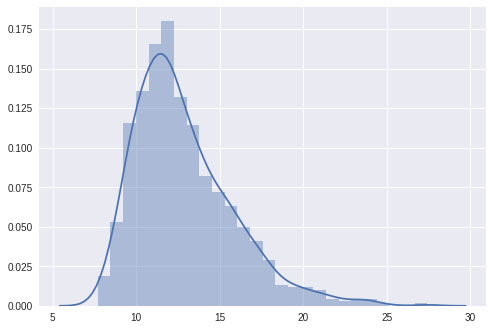

In [70]:
true_dog_centroid = np.mean(data_sets.train.x[data_sets.train.labels == 0, :], axis=0)
true_fish_centroid = np.mean(data_sets.train.x[data_sets.train.labels == 1, :], axis=0)
sns.distplot(np.linalg.norm(data_sets.train.x[data_sets.train.labels == 0, :] - true_dog_centroid, axis=1))
sns.distplot(np.linalg.norm(data_sets.train.x[data_sets.train.labels == 1, :] - true_fish_centroid, axis=1))

In [71]:
np.mean(np.linalg.norm(data_sets.train.x[data_sets.train.labels == 1, :] - true_fish_centroid, axis=1))

12.864819

In [59]:
np.linalg.norm(data_sets.train.x[idx_to_poison, :] - true_dog_centroid)

11.5826

In [60]:
np.linalg.norm(iter_f['poisoned_X_train_inception_features'] - true_dog_centroid)

11.250638

In [61]:
np.linalg.norm(data_sets.train.x[idx_to_poison, :] - true_fish_centroid)

12.974467

In [62]:
np.linalg.norm(iter_f['poisoned_X_train_inception_features'] - true_fish_centroid)

13.963262

In [63]:
np.linalg.norm(iter_f['poisoned_X_train_inception_features'] - data_sets.train.x[idx_to_poison, :])

11.132139

In [64]:
# L_infty distance in pixel space
np.max(np.abs(iter_f['poisoned_X_train_image'] - image_data_sets.train.x[idx_to_poison, :]))

0.0039215981960296631

In [66]:
# L2 distance in pixel space
np.linalg.norm(iter_f['poisoned_X_train_image'] - image_data_sets.train.x[idx_to_poison, :])

1.8819543581645286

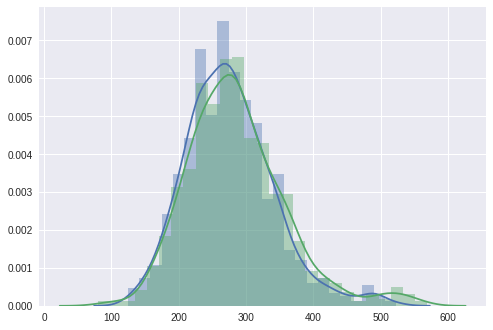

In [69]:
true_dog_pixel_centroid = np.mean(image_data_sets.train.x[image_data_sets.train.labels == 0, :], axis=0)
true_fish_pixel_centroid = np.mean(image_data_sets.train.x[image_data_sets.train.labels == 1, :], axis=0)
sns.distplot(np.linalg.norm(image_data_sets.train.x[image_data_sets.train.labels == 0, :] - true_dog_pixel_centroid, axis=1))
sns.distplot(np.linalg.norm(image_data_sets.train.x[image_data_sets.train.labels == 1, :] - true_fish_pixel_centroid, axis=1))

In [85]:
from sklearn.decomposition import PCA

X = data_sets.train.x[data_sets.train.labels == 1, :]
X = X - np.mean(X, axis=0)

pca = PCA(n_components=700)
pca.fit(X)
X_in_PC = np.linalg.norm(pca.transform(X), axis=1)
X_out_PC = np.linalg.norm(X, axis=1) - X_in_PC

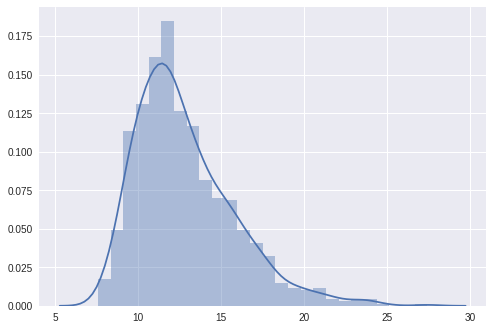

In [86]:
sns.distplot(X_in_PC)

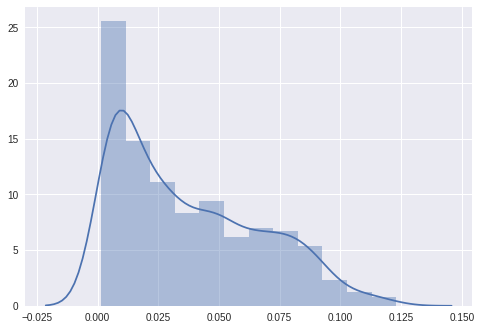

In [87]:
sns.distplot(X_out_PC)

In [88]:
poisoned_X = iter_f['poisoned_X_train_inception_features']

print(np.linalg.norm(pca.transform(poisoned_X)))
print(np.linalg.norm(poisoned_X) - np.linalg.norm(pca.transform(poisoned_X)))

20.1648789864
0.802760936727
